In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler

from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Loading Data**

In [ ]:
colnames=['id','name','t1', 't2', 'output', 'POSt1','POSt2'] 

train = pd.read_csv("train.data", error_bad_lines=False, sep='\t', names=colnames, header=None)
print("train data: {}".format(train.shape))

test = pd.read_csv("test.data", error_bad_lines=False, sep='\t', names=colnames, header=None)
print("test data: {}".format(test.shape))

dev = pd.read_csv("dev.data", error_bad_lines=False, sep='\t', names=colnames, header=None)
print("dev data: {}".format(dev.shape))

train data: (13063, 7)
test data: (972, 7)
dev data: (4727, 7)


In [ ]:
train.head()

,id,name,t1,t2,output,POSt1,POSt2
0,4,1st QB,EJ Manuel the 1st QB to go in this draft,But my bro from the 757 EJ Manuel is the 1st Q...,"(5, 0)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,But/O/CC/O/O my/O/PRP$/B-NP/O bro/O/NN/I-NP/O ...
1,4,1st QB,EJ Manuel the 1st QB to go in this draft,Can believe EJ Manuel went as the 1st QB in th...,"(5, 0)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,Can/O/MD/B-VP/O believe/O/VB/I-VP/B-EVENT EJ/B...
2,4,1st QB,EJ Manuel the 1st QB to go in this draft,EJ MANUEL IS THE 1ST QB what,"(3, 2)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,EJ/B-person/NNP/B-NP/O MANUEL/I-person/NNP/I-N...
3,4,1st QB,EJ Manuel the 1st QB to go in this draft,EJ da 1st QB off da board,"(2, 3)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,EJ/O/NNP/B-NP/O da/O/DT/I-NP/O 1st/O/CD/I-NP/O...
4,4,1st QB,EJ Manuel the 1st QB to go in this draft,Manuel is the 1st QB to get drafted,"(4, 1)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,Manuel/B-person/NNP/B-NP/O is/O/VBZ/B-VP/O the...


In [ ]:
cols_of_interest = ['t1', 't2', 'output']

train = train[cols_of_interest]
test = test[cols_of_interest]
dev = dev[cols_of_interest]

In [ ]:
train.head()

,t1,t2,output
0,EJ Manuel the 1st QB to go in this draft,But my bro from the 757 EJ Manuel is the 1st Q...,"(5, 0)"
1,EJ Manuel the 1st QB to go in this draft,Can believe EJ Manuel went as the 1st QB in th...,"(5, 0)"
2,EJ Manuel the 1st QB to go in this draft,EJ MANUEL IS THE 1ST QB what,"(3, 2)"
3,EJ Manuel the 1st QB to go in this draft,EJ da 1st QB off da board,"(2, 3)"
4,EJ Manuel the 1st QB to go in this draft,Manuel is the 1st QB to get drafted,"(4, 1)"


In [ ]:
# converting to binary
# paraphrases: (3, 2) (4, 1) (5, 0)
# non-paraphrases: (1, 4) (0, 5)
# debatable: (2, 3)  which you may discard if training binary classifier

# paraphrase: 1
# not-paraphrase: 0
def binary(x):
    if x > 2: return 1
    else: return 0

#train['output'] = train['output'].apply(lambda x: binary(int(x[1])))
#dev['output'] = dev['output'].apply(lambda x: binary(int(x[1])))

In [ ]:
dev.head()

,t1,t2,output
0,A Walk to Remember is the definition of true love,A Walk to Remember is on and Im in town and Im...,0
1,A Walk to Remember is the definition of true love,A Walk to Remember is the cutest thing,1
2,A Walk to Remember is the definition of true love,A walk to remember is on ABC family youre welcome,0
3,A Walk to Remember is the definition of true love,A walk to remember is so amazing and inspiring,1
4,A Walk to Remember is the definition of true love,BUT GUYS ITS ON MY FAVE PART OF A WALK TO REME...,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13063 entries, 0 to 13062
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   t1      13063 non-null  object
 1   t2      13063 non-null  object
 2   output  13063 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 306.3+ KB


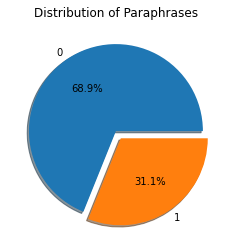

In [ ]:
ax=dev['output'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Paraphrases')
ax.set_ylabel('')
plt.show()

paraphrase:  1470
Not paraphrase :  3257


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


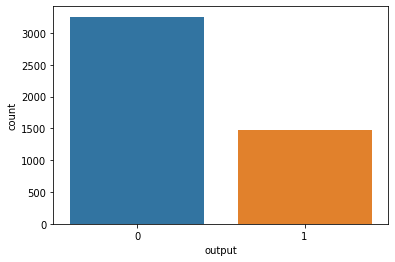

In [ ]:
plot_sb = sb.countplot(dev['output'], label='output')
no, yes  = dev['output'].value_counts()
print('paraphrase: ', yes)
print('Not paraphrase : ', no)

In [ ]:
# preprocessing tweets
def clean_tweet(text):
    ''' Function that is applied to every to tweet in the dataset '''

    # =========== TEXT ===========
    # Replace @USER by <user>
    text = re.compile(r'@USER').sub(r'<user>',text)

    # Replace URL by <url>
    text = re.compile(r'URL').sub(r'<url>',text)

    # Remove numbers :
    text = re.compile(r'[0-9]+').sub(r' ',text)

    # Remove some special characters
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) 

    # Space the special characters with white spaces
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)

    # Replace some special characters : 
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    # Handle Emoji : translate some and delete the others
    text = handle_emoji(text)

    # Word delengthening : 
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    # =========== TOKENS ===========
    # TOKENIZE 
    text = text.split(' ')

    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

**Helper Functions**

In [ ]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

def overlap(s1,s2):
  s = s1 + s2
  s = set(s)
  if len(s1) > len(s2):
    min_len = len(s2)
  else:
    min_len = len(s1)
  
  if (len(s)/min_len) < 0.8 : return 0
  else: return 1  

**Baseline Model**

In [ ]:
# https://cla2019.github.io/paraphrases_scikit_numpy.pdf
#  Number of common words that occur in both tweets

In [ ]:


dev_prediction = []

for i, row in dev.iterrows():
  pred = overlap(row['t1'], row['t2'])
  dev_prediction.append(pred)

dev['baseline'] = dev_prediction  

In [ ]:
dev.head()

,t1,t2,output,baseline
0,A Walk to Remember is the definition of true love,A Walk to Remember is on and Im in town and Im...,0,0
1,A Walk to Remember is the definition of true love,A Walk to Remember is the cutest thing,1,0
2,A Walk to Remember is the definition of true love,A walk to remember is on ABC family youre welcome,0,0
3,A Walk to Remember is the definition of true love,A walk to remember is so amazing and inspiring,1,0
4,A Walk to Remember is the definition of true love,BUT GUYS ITS ON MY FAVE PART OF A WALK TO REME...,0,1


In [ ]:
print(classification_report(dev['output'], dev['baseline']))

              precision    recall  f1-score   support

           0       0.62      0.43      0.51      3257
           1       0.25      0.41      0.31      1470

    accuracy                           0.43      4727
   macro avg       0.43      0.42      0.41      4727
weighted avg       0.51      0.43      0.45      4727



Sensitivity: 41.36%
Specificity: 43.41%


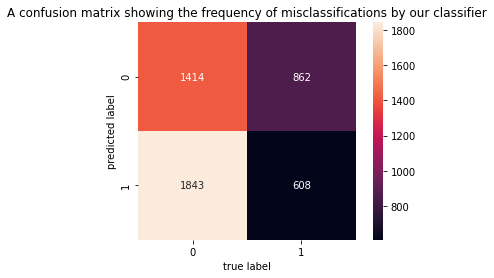

In [ ]:
getConfusionMatrix(dev['output'], dev['baseline'])

In [ ]:
# Use accuracy_score function to get the accuracy
print("Accuracy Score",accuracy_score(dev['baseline'], dev['output'])*100)

print('F1Score', f1_score(dev['baseline'], dev['output'], average="macro"))
print('Precision', precision_score(dev['baseline'], dev['output'], average="macro"))
print('Recall', recall_score(dev['baseline'], dev['output'], average="macro"))

Accuracy Score 42.77554474296594
F1Score 0.4106200477688459
Precision 0.42387364525177584
Recall 0.43466369667988175


**ML Models**

In [ ]:
#  data transformation
train["tweets"] = train["t1"] + train["t2"]
test["tweets"] = test["t1"] + test["t2"]
dev["tweets"] = dev["t1"] + dev["t2"]

X_train = train['tweets']
y_train = train['output']

X_test = test['tweets']
y_test = test['output']

X_dev = dev['tweets']
y_dev = dev['output']

In [ ]:
def tfidf_vectorizer(X, train_X, test_X):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X)

    train_text_features_tf = tfidf_vectorizer.transform(train_X)
    test_text_features_tf = tfidf_vectorizer.transform(test_X)
    
    return train_text_features_tf, test_text_features_tf

def model(model, train_text_features, train_y, test_text_features, test_y):
        
    model.fit(train_text_features, train_y)

    # predict the labels on validation dataset
    predictions = model.predict(test_text_features)

    # Use accuracy_score function to get the accuracy
    print("Accuracy Score ",accuracy_score(predictions, test_y)*100)

    print('F1Score', f1_score(predictions, test_y, average="macro"))
    print('Precision', precision_score(predictions, test_y, average="macro"))
    print('Recall', recall_score(predictions, test_y, average="macro"))

    getConfusionMatrix(test_y, predictions)

    print(classification_report(test_y, predictions))

In [ ]:
train_text_features, test_text_features = tfidf_vectorizer(X_train, X_train, X_dev)

Accuracy Score  69.21937804104083
F1Score 0.4311990224719798
Precision 0.5088344518034417
Recall 0.6646073318804483
Sensitivity: 2.38%
Specificity: 99.39%


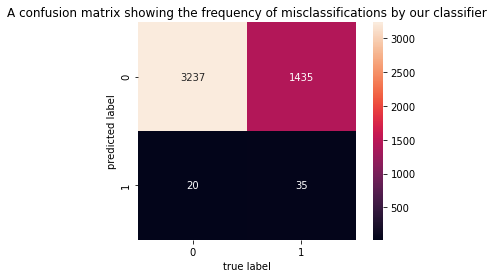

              precision    recall  f1-score   support

           0       0.69      0.99      0.82      3257
           1       0.64      0.02      0.05      1470

    accuracy                           0.69      4727
   macro avg       0.66      0.51      0.43      4727
weighted avg       0.68      0.69      0.58      4727



In [ ]:
model(naive_bayes.MultinomialNB(), train_text_features, y_train, test_text_features, y_dev)

Accuracy Score  68.7539665749947
F1Score 0.44413229305871865
Precision 0.5103092449752391
Recall 0.5832153177485324
Sensitivity: 4.15%
Specificity: 97.91%


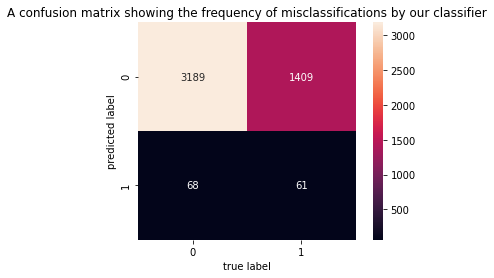

              precision    recall  f1-score   support

           0       0.69      0.98      0.81      3257
           1       0.47      0.04      0.08      1470

    accuracy                           0.69      4727
   macro avg       0.58      0.51      0.44      4727
weighted avg       0.62      0.69      0.58      4727



In [ ]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), train_text_features, y_train, test_text_features, y_dev)

Accuracy Score  68.92320710810239
F1Score 0.40867179261709513
Precision 0.5003401360544217
Recall 0.8445831570038087
Sensitivity: 0.07%
Specificity: 100.00%


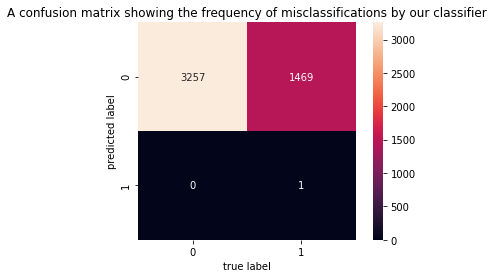

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3257
           1       1.00      0.00      0.00      1470

    accuracy                           0.69      4727
   macro avg       0.84      0.50      0.41      4727
weighted avg       0.79      0.69      0.56      4727



In [ ]:
model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), train_text_features, y_train, test_text_features, y_dev)

**Word Embeddings**

In [ ]:
pip install zeugma > /dev/null

In [ ]:
#https://stackoverflow.com/questions/55198750/using-pretrained-glove-word-embedding-with-scikit-learn
from zeugma.embeddings import EmbeddingTransformer
glove = EmbeddingTransformer('conceptnet-numberbatch-17-06-300')

[=================================================-] 99.3% 1161.1/1168.7MB downloaded


In [ ]:
train_text_features = glove.transform(X_train)
test_text_features = glove.transform(X_dev)

Accuracy Score  68.90205204146393
F1Score 0.40794088176352705
Precision 0.5
Recall 0.3445102602073197
Sensitivity: 0.00%
Specificity: 100.00%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


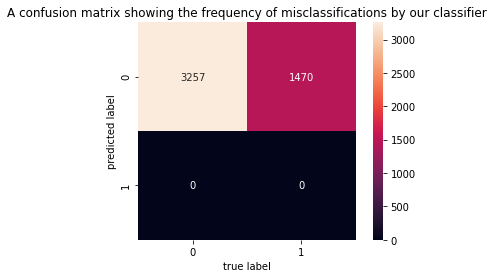

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3257
           1       0.00      0.00      0.00      1470

    accuracy                           0.69      4727
   macro avg       0.34      0.50      0.41      4727
weighted avg       0.47      0.69      0.56      4727



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), train_text_features, y_train, test_text_features, y_dev)